In [46]:
import numpy as np
from gaussian_process import GaussianProcess, matern52_kernel, rbf_kernel
from bayes_opt import BayesianOptimisation, expected_improvement
from samplers import gaussian_sampling
from objectives import log_likelihood
import matplotlib.pyplot as plt
from parameter_estimation import estimate_params
from lensmodel import mean_function_theta
from packages.utils import read_and_convert, plot_final_params
import seaborn as sns

In [38]:
sns.set_theme(style="white", context="paper")
plt.rcParams.update(
    {
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 10,
        "figure.dpi": 300,
        "savefig.format": "png",
        "figure.figsize": (6, 4),
    }
)

In [47]:
def filter_data(time, mags, mags_error, time_range=200):
    mag_peak = np.max(mags)
    peak_time = time[np.argmax(mags)]
    mask = (time >= peak_time - time_range) & (time <= peak_time + time_range)
    return time[mask], mags[mask], mags_error[mask]

Initial predictions:
    t_0: 2459997.9749691808 ± 1.2021023299945999
    u_min: 0.10802306426881934 ± 0.00743361041096234
    t_E: 164.3550836721577 ± 62.1044800194141


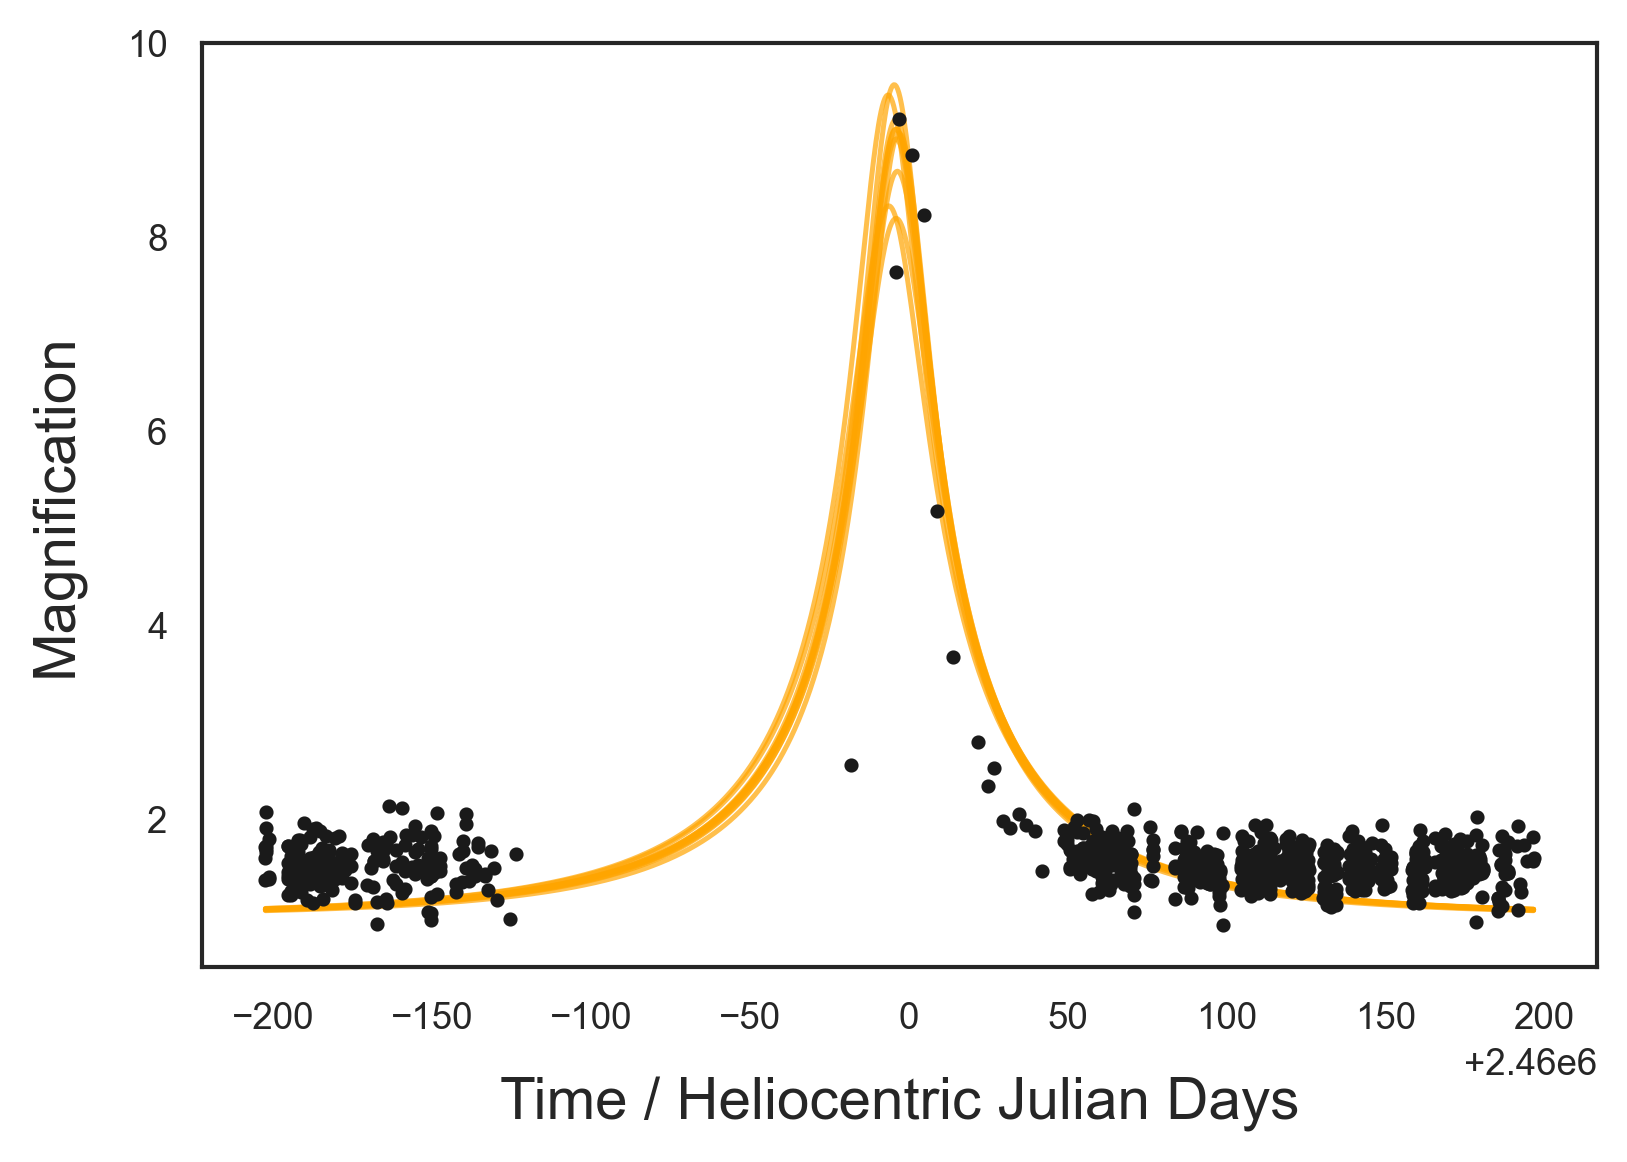

Final predictions:
    t_0: 2459995.5867047505 ± 1.0787896584446304
    u_min: 0.11218547546947244 ± 0.005557898271450011
    t_E: 102.92343975320046 ± 2.8797948382354686


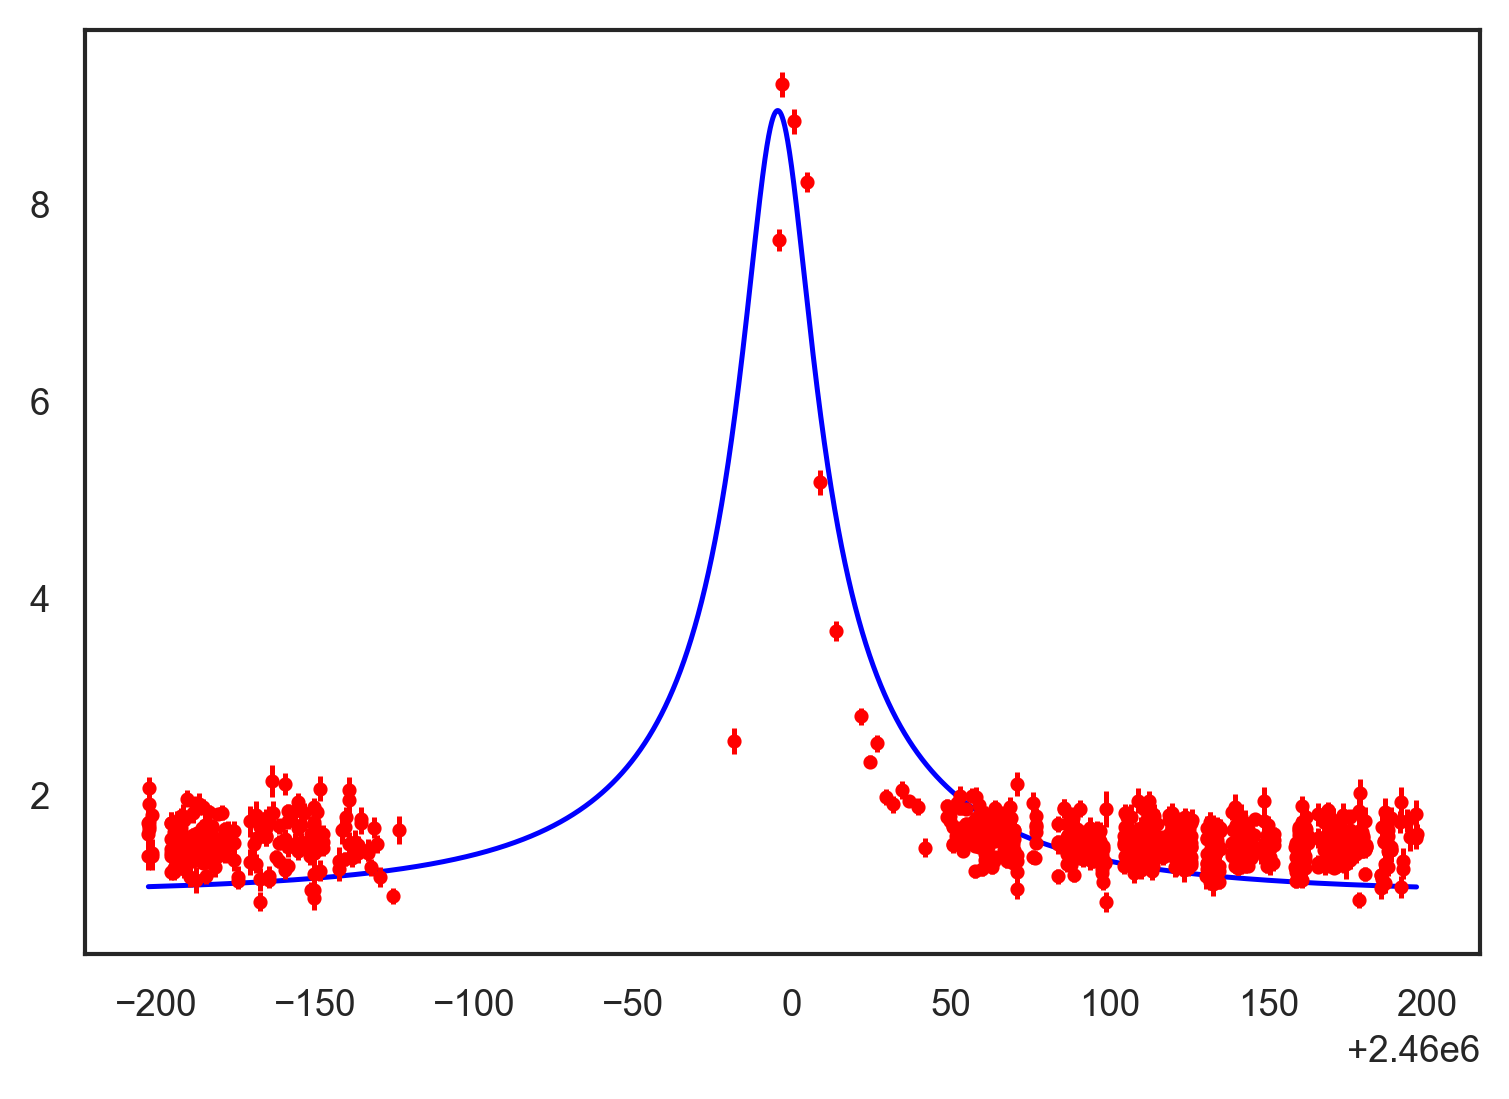

In [48]:
# hyperparameters:
# matern52_kernel: sigma_l=1, sigma_f=1
# gaussian_sampling: sigma=1
# expected_improvement

# define the hyperparameters
I_0 = 19.956 - 0.361 * 2
f_s = 0.528
kernel = "matern52_kernel"
sigma_l = 1

# read the data
datafile = "0002"
time, mags, mags_error = read_and_convert(
    f"sample_data_OGLE/OGLE-2023-BLG-{datafile}.dat", I_0, f_s
)
# filter the data too far from the main signal
time, mags, mags_error = filter_data(time, mags, mags_error)


# settng params for initial estimation
observed_times, magnifications, magnification_errors = time, mags, mags_error
parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}
bounds = parameter_bounds
mean_function = None
sigma = 1


bounds["t_0"] = [
    np.min(observed_times),
    np.max(observed_times),
]  # Change bounds on t_0 before estimating

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []

# Run the Bayesian optimisation 10 times to get a distribution of the best parameters
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=sigma_l, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])
    params = optimiser.x_samples[optimiser.current_best_index]

    # plot the best fit
    time_array = np.linspace(np.min(observed_times), np.max(observed_times), 1000)
    theta = [params[0], params[2]]
    mags = mean_function_theta(time_array, theta, params[1])
    plt.plot(time_array, mags, color="orange", alpha=0.7)

# Plot the observed data on top of the best fit
plt.plot(observed_times, magnifications, "k.", label="Observed data")
plt.xlabel("Time / Heliocentric Julian Days")
plt.ylabel("Magnification")
plt.savefig(f"plots/best_fit_overlap{kernel, sigma_l, datafile}.png", dpi=300)
plt.show()

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)


plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)

0.5667775852068442

**consider OGLE 0019 for consistency**

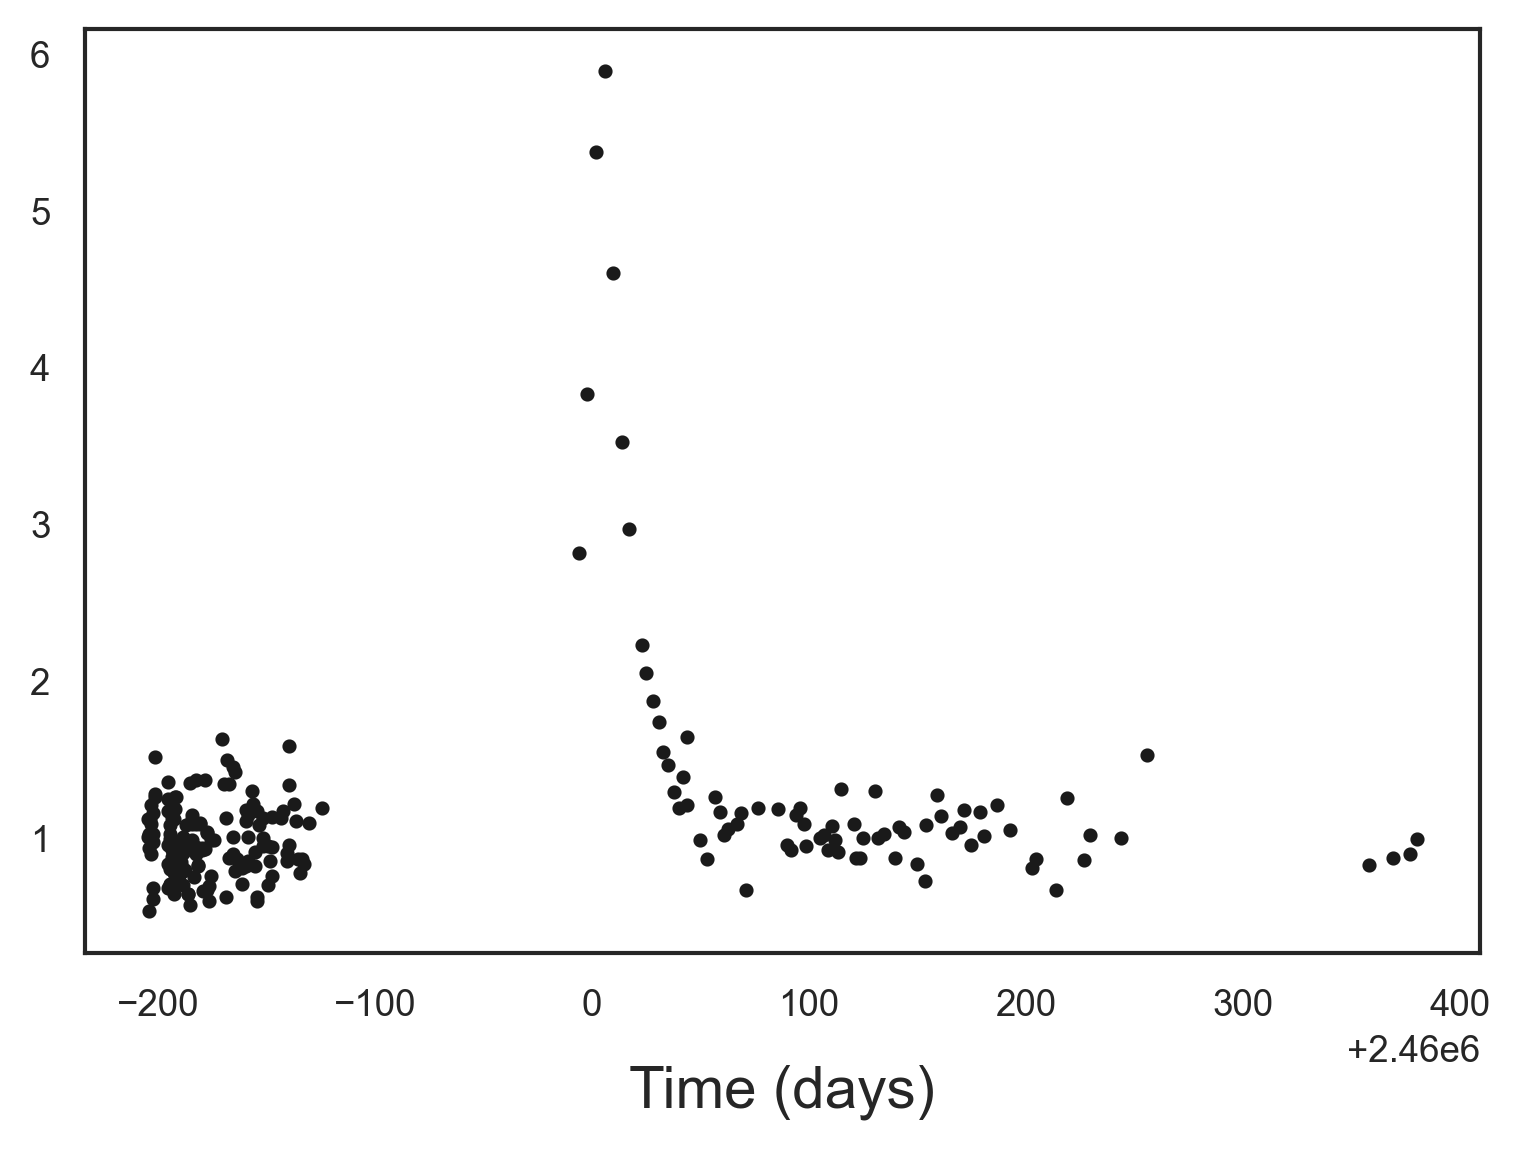

In [39]:
# hyperparameters:
# matern52_kernel: sigma_l=1, sigma_f=1
# gaussian_sampling: sigma=1
# expected_improvement

I_0 = 19.956 - 0.361 * 2
f_s = 0.528
time, mags, mags_error = read_and_convert(
    "sample_data_OGLE/OGLE-2023-BLG-0019.dat", I_0, f_s
)

# observe the data for time range selection
plt.plot(time, mags, "k.")
plt.xlabel("Time (days)")
plt.show()

Initial predictions:
    t_0: 2460005.539281274 ± 1.3094646193106436
    u_min: 0.17261785368102878 ± 0.01095072542078834
    t_E: 59.91143468845576 ± 35.3962678729633
Final predictions:
    t_0: 2460005.2062778515 ± 0.1298532300877284
    u_min: 0.1711843404584133 ± 0.0052772564645330545
    t_E: 34.73312290109211 ± 0.6456217821709834


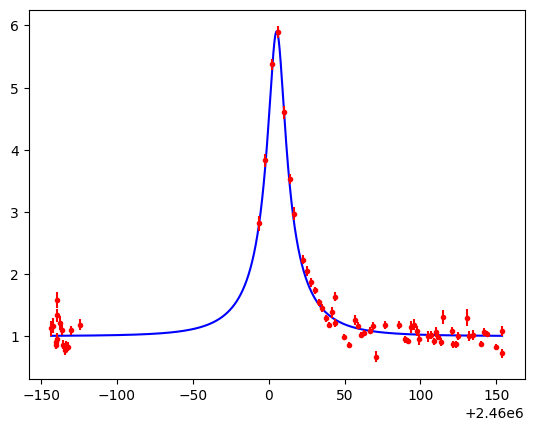

In [23]:
# from the plot, we can see that the a time range of 150 would be reasonable
mag_peak = np.max(mags)
peak_time = time[np.argmax(mags)]
time_range = 150  # Adjust this as needed
mask = (time >= peak_time - time_range) & (time <= peak_time + time_range)
magnifications = mags[mask]
time = time[mask]
mags = mags[mask]
mags_error = mags_error[mask]


observed_times = time
magnifications = mags
magnification_errors = mags_error

parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}

bounds = parameter_bounds

mean_function = None
sigma = 1

# Change bounds on t_0 before estimating
bounds["t_0"] = [np.min(observed_times), np.max(observed_times)]

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=1, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)

plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)

Initial predictions:
    t_0: 2460005.5534739187 ± 1.2788853091066856
    u_min: 0.17271980302758283 ± 0.010844305269300093
    t_E: 92.66685408161207 ± 53.861159525319515


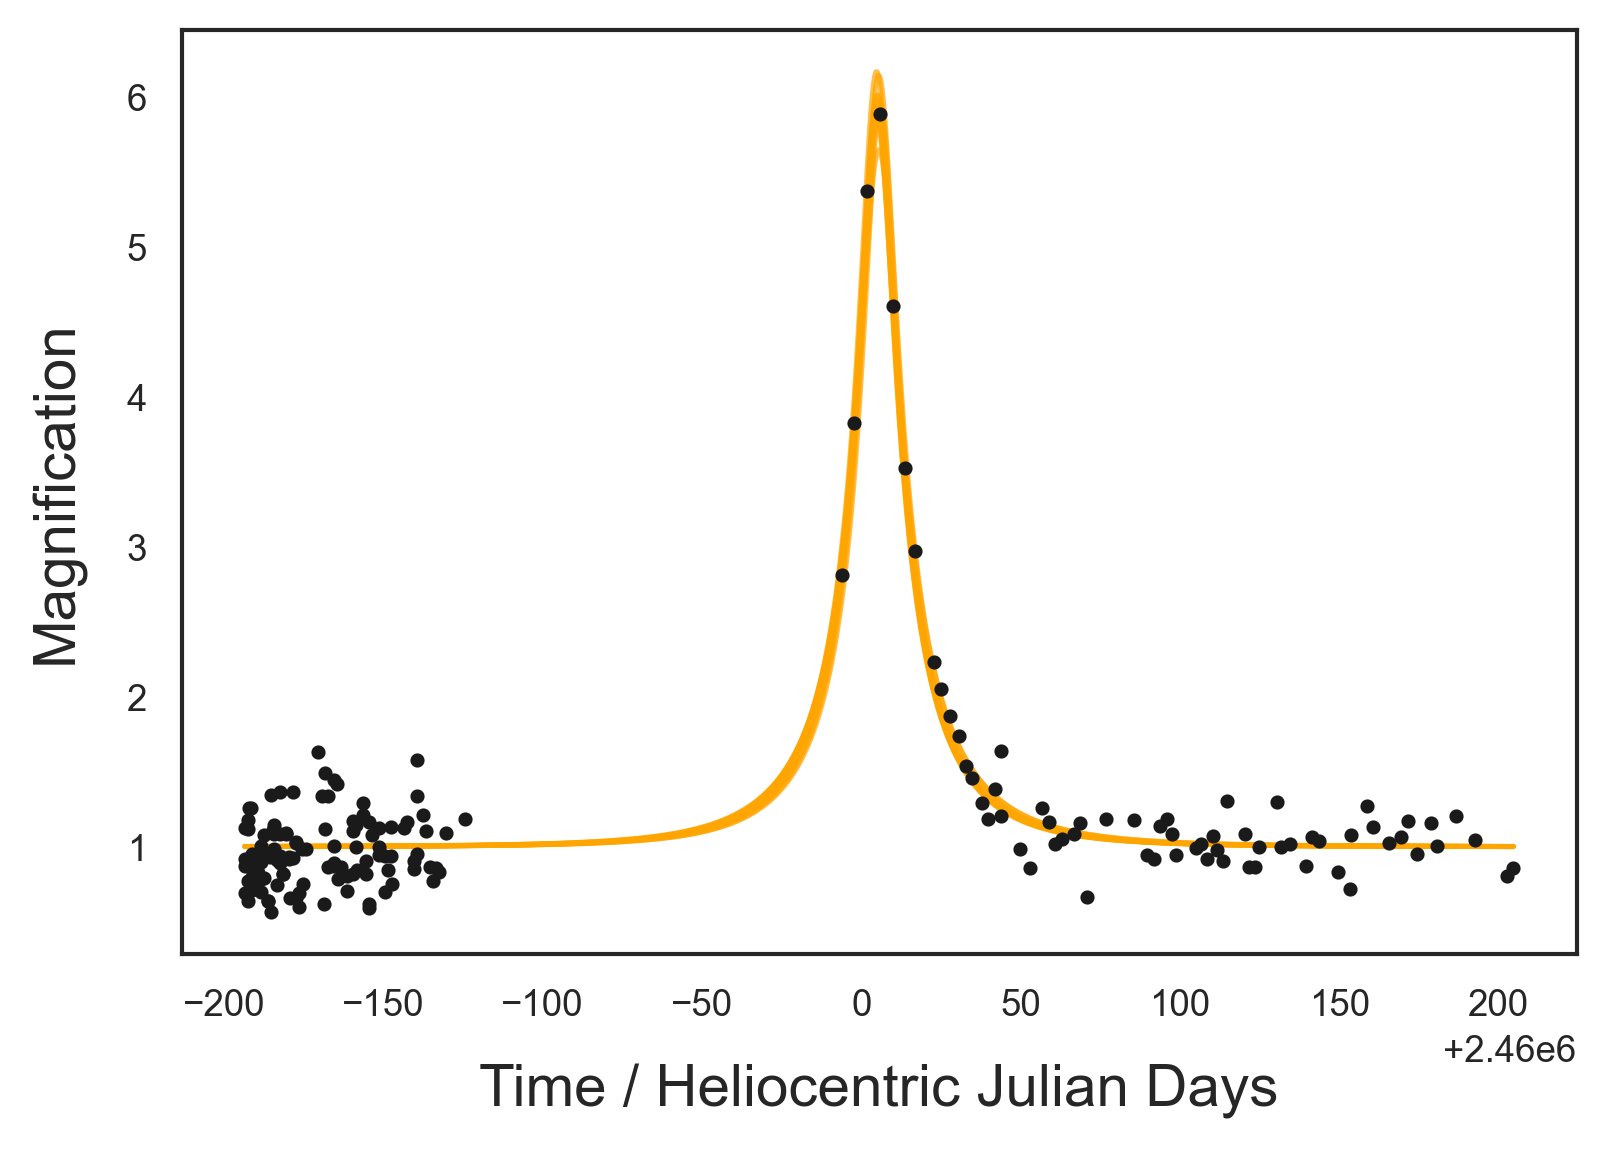

Final predictions:
    t_0: 2460005.237287539 ± 0.38896133097548835
    u_min: 0.1699099178662386 ± 0.004284956152495176
    t_E: 20.971046194388425 ± 27.92530560866547


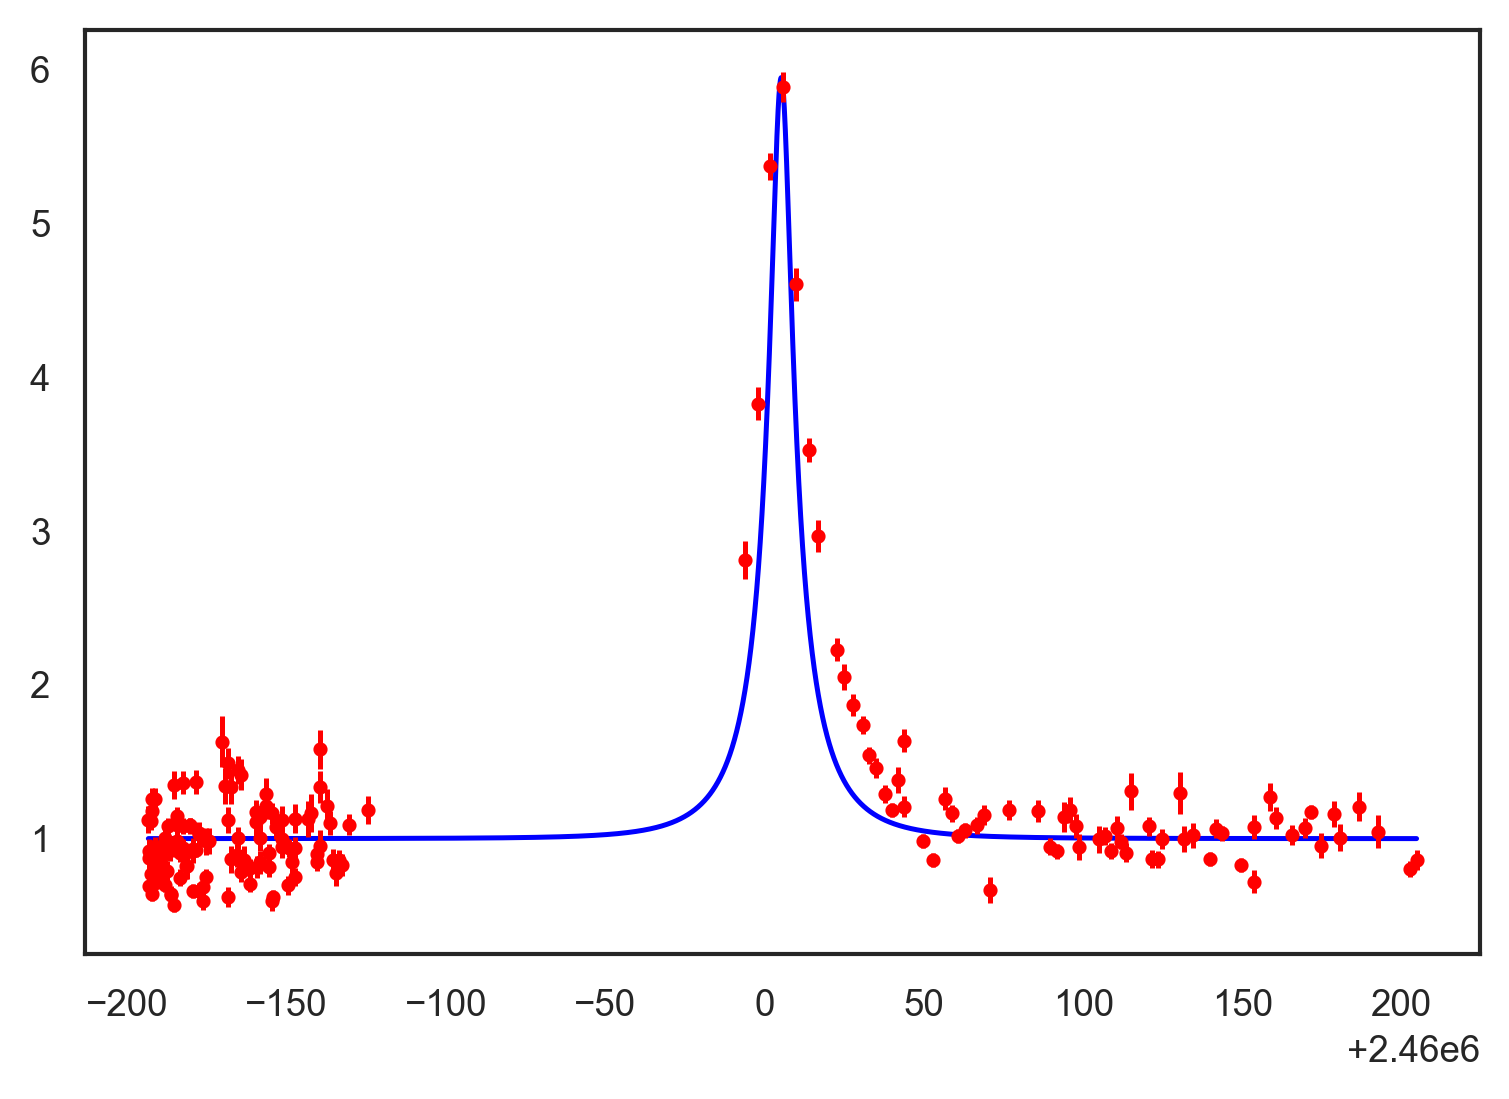

In [49]:
# hyperparameters:
# matern52_kernel: sigma_l=1, sigma_f=1
# gaussian_sampling: sigma=1
# expected_improvement

# define the hyperparameters
I_0 = 19.956 - 0.361 * 2
f_s = 0.528
kernel = "matern52_kernel"
sigma_l = 1

# read the data
datafile = "0019"
time, mags, mags_error = read_and_convert(
    f"sample_data_OGLE/OGLE-2023-BLG-{datafile}.dat", I_0, f_s
)
# filter the data too far from the main signal
time, mags, mags_error = filter_data(time, mags, mags_error)


# settng params for initial estimation
observed_times, magnifications, magnification_errors = time, mags, mags_error
parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}
bounds = parameter_bounds
mean_function = None
sigma = 1


bounds["t_0"] = [
    np.min(observed_times),
    np.max(observed_times),
]  # Change bounds on t_0 before estimating

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []

# Run the Bayesian optimisation 10 times to get a distribution of the best parameters
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=matern52_kernel, sigma_l=sigma_l, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])
    params = optimiser.x_samples[optimiser.current_best_index]

    # plot the best fit
    time_array = np.linspace(np.min(observed_times), np.max(observed_times), 1000)
    theta = [params[0], params[2]]
    mags = mean_function_theta(time_array, theta, params[1])
    plt.plot(time_array, mags, color="orange", alpha=0.7)

# Plot the observed data on top of the best fit
plt.plot(observed_times, magnifications, "k.", label="Observed data")
plt.xlabel("Time / Heliocentric Julian Days")
plt.ylabel("Magnification")
plt.savefig(f"plots/best_fit_overlap{kernel, sigma_l, datafile}.png", dpi=300)
plt.show()

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)


plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)

Initial predictions:
    t_0: 2460005.5534739187 ± 1.2788853091066856
    u_min: 0.17271980302758283 ± 0.010844305269300093
    t_E: 92.66685408161207 ± 53.861159525319515


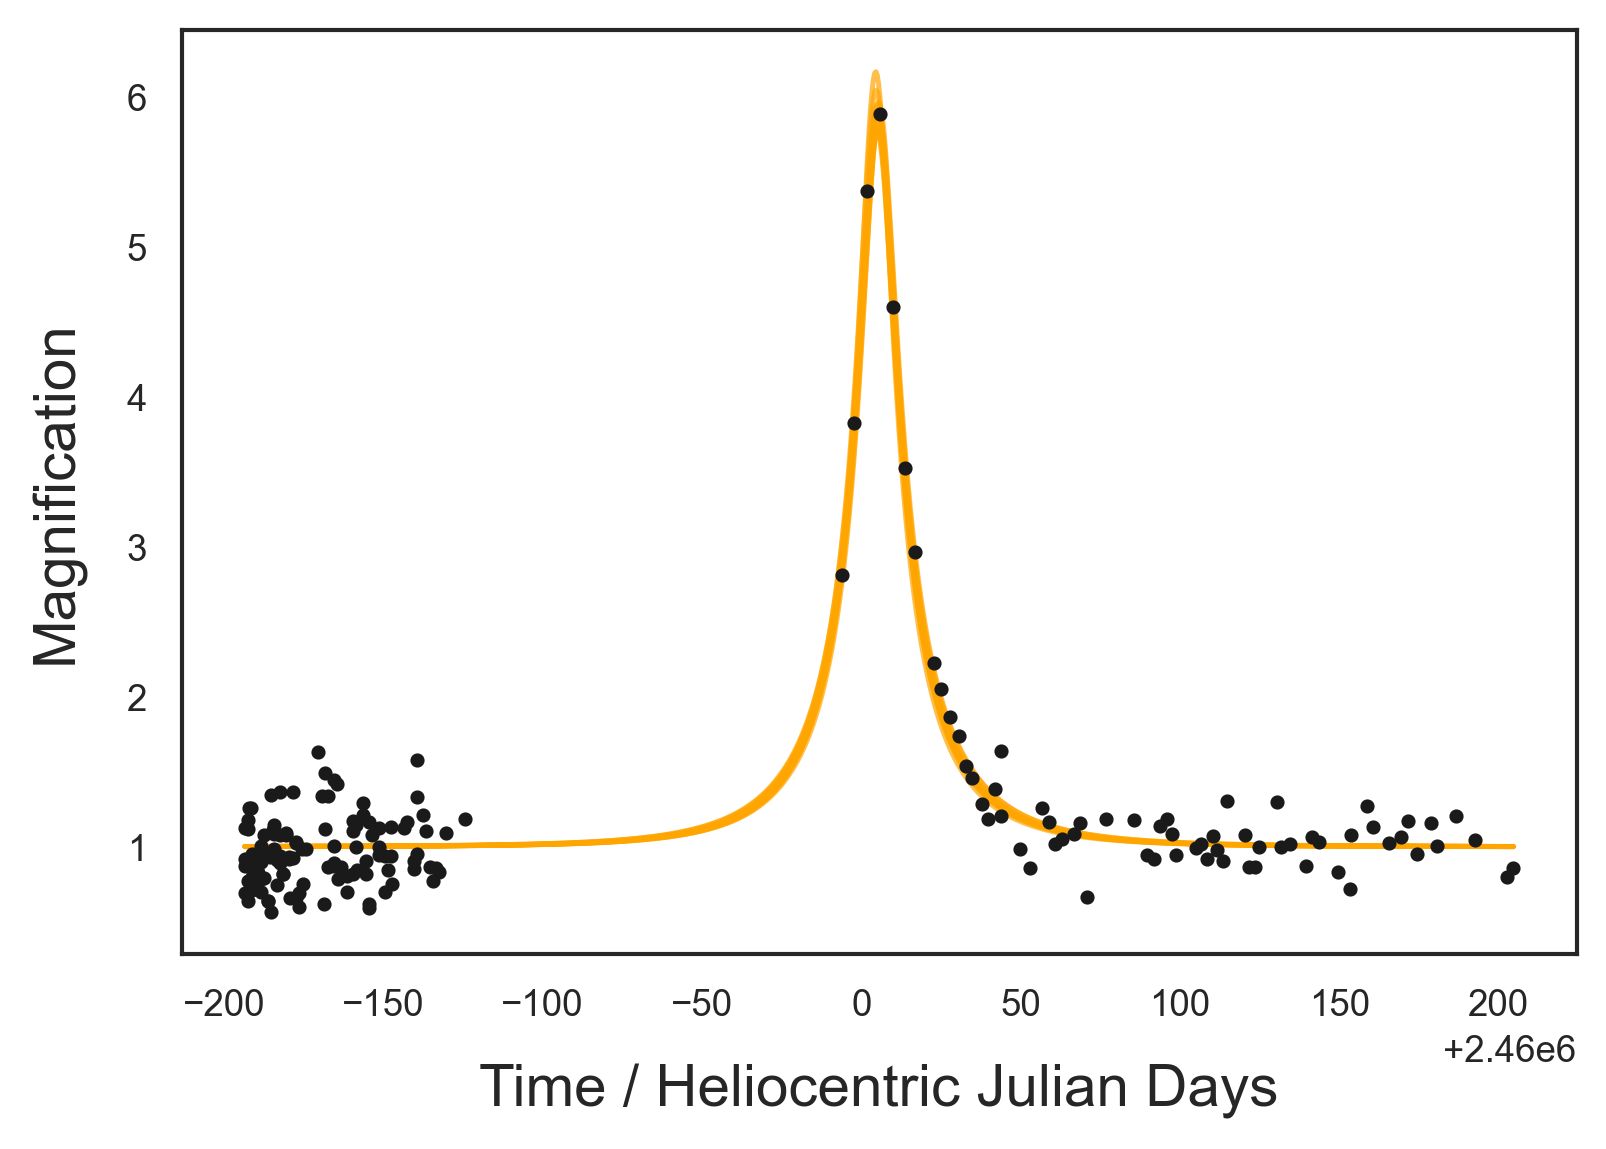

Final predictions:
    t_0: 2460005.1235006154 ± 0.3475278513012952
    u_min: 0.171073717514781 ± 0.0035233564228704353
    t_E: 35.168160618034015 ± 1.079233892258757


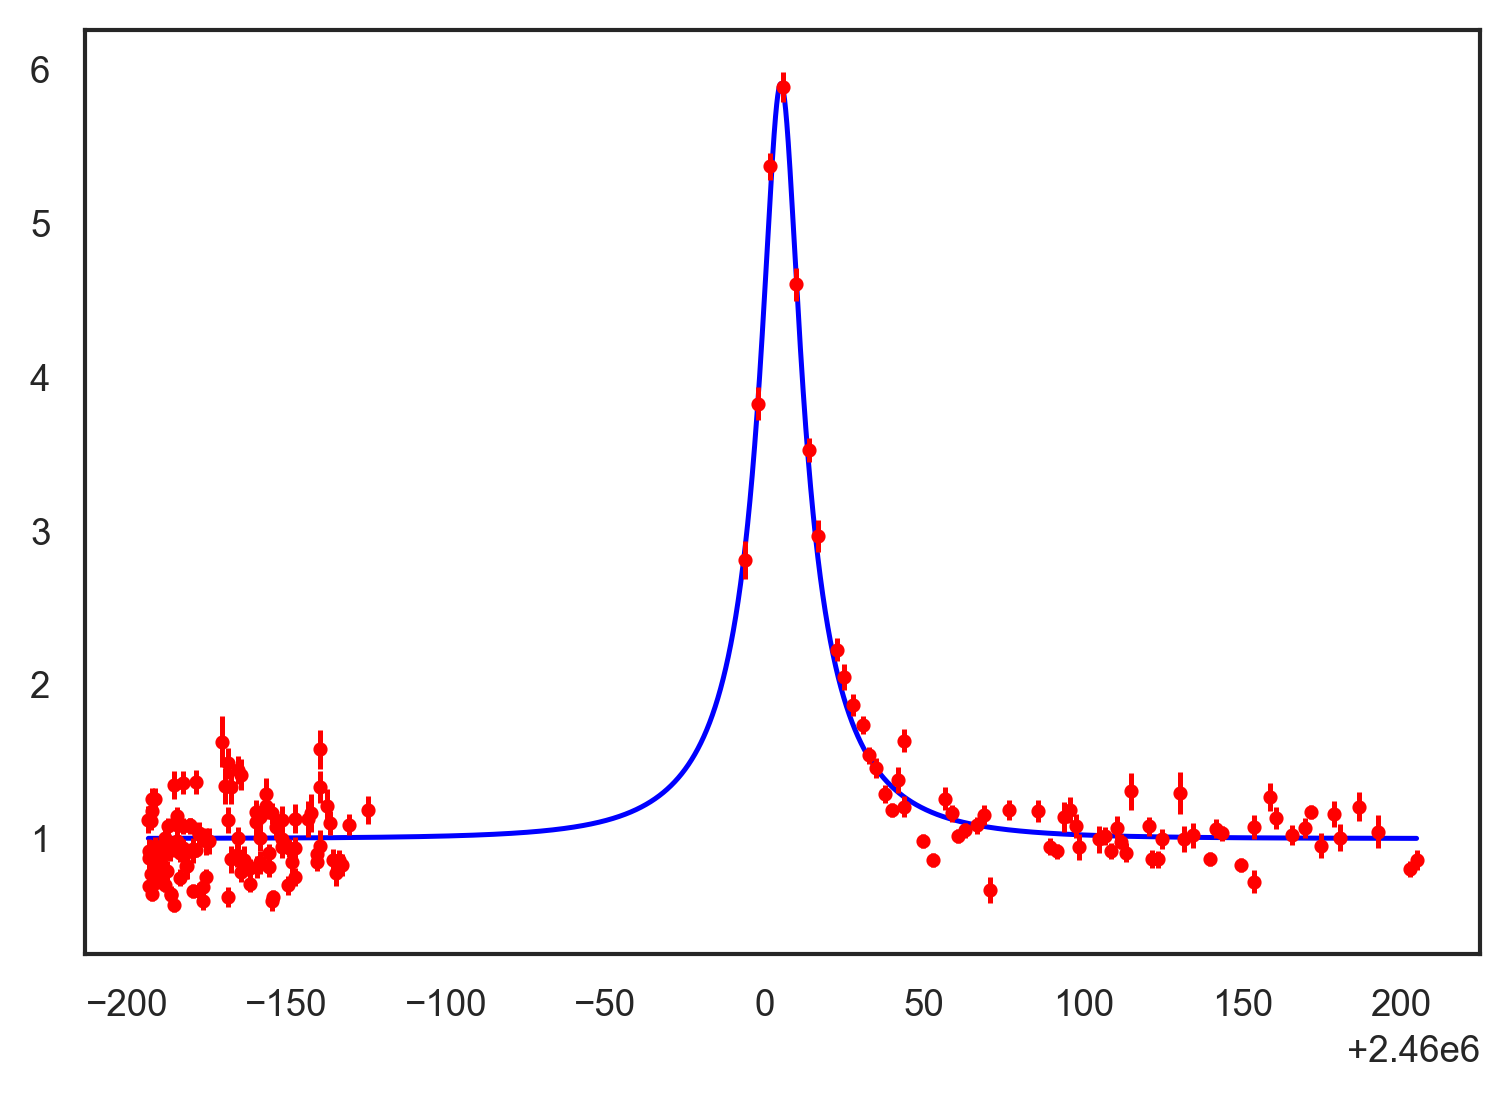

In [50]:
# hyperparameters:
# matern52_kernel: sigma_l=1, sigma_f=1
# gaussian_sampling: sigma=1
# expected_improvement

# define the hyperparameters
I_0 = 19.956 - 0.361 * 2
f_s = 0.528
kernel = "rbf_kernel"
sigma_l = 1

if kernel == "matern52_kernel":
    kernel = matern52_kernel
elif kernel == "rbf_kernel":
    kernel = rbf_kernel

# read the data
datafile = "0019"
time, mags, mags_error = read_and_convert(
    f"sample_data_OGLE/OGLE-2023-BLG-{datafile}.dat", I_0, f_s
)
# filter the data too far from the main signal
time, mags, mags_error = filter_data(time, mags, mags_error)


# settng params for initial estimation
observed_times, magnifications, magnification_errors = time, mags, mags_error
parameter_bounds = {
    "t_E": [0.01, 700],  # days
    "t_0": [-5, 5],  # days (placeholder, updated in the code)
    "u_min": [0, 4],  # unitless
}
bounds = parameter_bounds
mean_function = None
sigma = 1


bounds["t_0"] = [
    np.min(observed_times),
    np.max(observed_times),
]  # Change bounds on t_0 before estimating

# Estimate parameters using bootstrapping
t_E, t_E_error, t_0, t_0_error, u_min, u_min_error = estimate_params(
    observed_times, magnifications, bounds, magnification_errors
)

print(
    "Initial predictions:\n"
    f"    t_0: {t_0} \u00B1 {sigma*t_0_error}\n"
    f"    u_min: {u_min} \u00B1 {sigma*u_min_error}\n"
    f"    t_E: {t_E} \u00B1 {sigma*t_E_error}"
)

# Changes bounds to take into account predictions
bounds["t_0"] = [t_0 - sigma * t_0_error, t_0 + sigma * t_0_error]
bounds["t_E"] = [t_E - sigma * t_E_error, t_E + sigma * t_E_error]
bounds["u_min"] = [u_min - sigma * u_min_error, u_min + sigma * u_min_error]

parameter_samples = []

# Run the Bayesian optimisation 10 times to get a distribution of the best parameters
for i in range(10):
    # Define surrogate Gaussian process
    gp = GaussianProcess(kernel=rbf_kernel, sigma_l=sigma_l, sigma_f=1)

    # Define Bayesian optimisation
    optimiser = BayesianOptimisation(
        surrogate=gp,
        acquisition=expected_improvement,
        objective=log_likelihood,
        bounds=parameter_bounds,
        sampler=gaussian_sampling,
    )

    optimiser.mag_err = magnification_errors

    # Fit for parameters using the defined Bayesian optimiser
    optimiser.fit(observed_times, magnifications, 400)

    # Plot regret and results
    # optimiser.regret_plot()
    # optimiser.plot_best_param()

    # Append found parameters to the list of all predictions
    parameter_samples.append(optimiser.x_samples[optimiser.current_best_index])
    params = optimiser.x_samples[optimiser.current_best_index]

    # plot the best fit
    time_array = np.linspace(np.min(observed_times), np.max(observed_times), 1000)
    theta = [params[0], params[2]]
    mags = mean_function_theta(time_array, theta, params[1])
    plt.plot(time_array, mags, color="orange", alpha=0.7)

# Plot the observed data on top of the best fit
plt.plot(observed_times, magnifications, "k.", label="Observed data")
plt.xlabel("Time / Heliocentric Julian Days")
plt.ylabel("Magnification")
plt.savefig(f"plots/best_fit_overlap{kernel, sigma_l, datafile}.png", dpi=300)
plt.show()

# Calculate the best parameters and their errors as a mean and standard deviation of the 10 runs
best_parameters = np.mean(parameter_samples, axis=0)
best_parameter_errors = np.std(parameter_samples, axis=0)

print(
    "Final predictions:\n"
    f"    t_0: {best_parameters[1]} \u00B1 {best_parameter_errors[1]}\n"
    f"    u_min: {best_parameters[2]} \u00B1 {best_parameter_errors[2]}\n"
    f"    t_E: {best_parameters[0]} \u00B1 {best_parameter_errors[0]}"
)


plot_final_params(
    observed_times, magnifications, best_parameters, mags_error=mags_error
)